## <center> Kickstarter Crowdfunding: Predicting Funding Success Using NLP and XGBoost
## <center>  Mikhail Gorshunov
## <center> April 2022

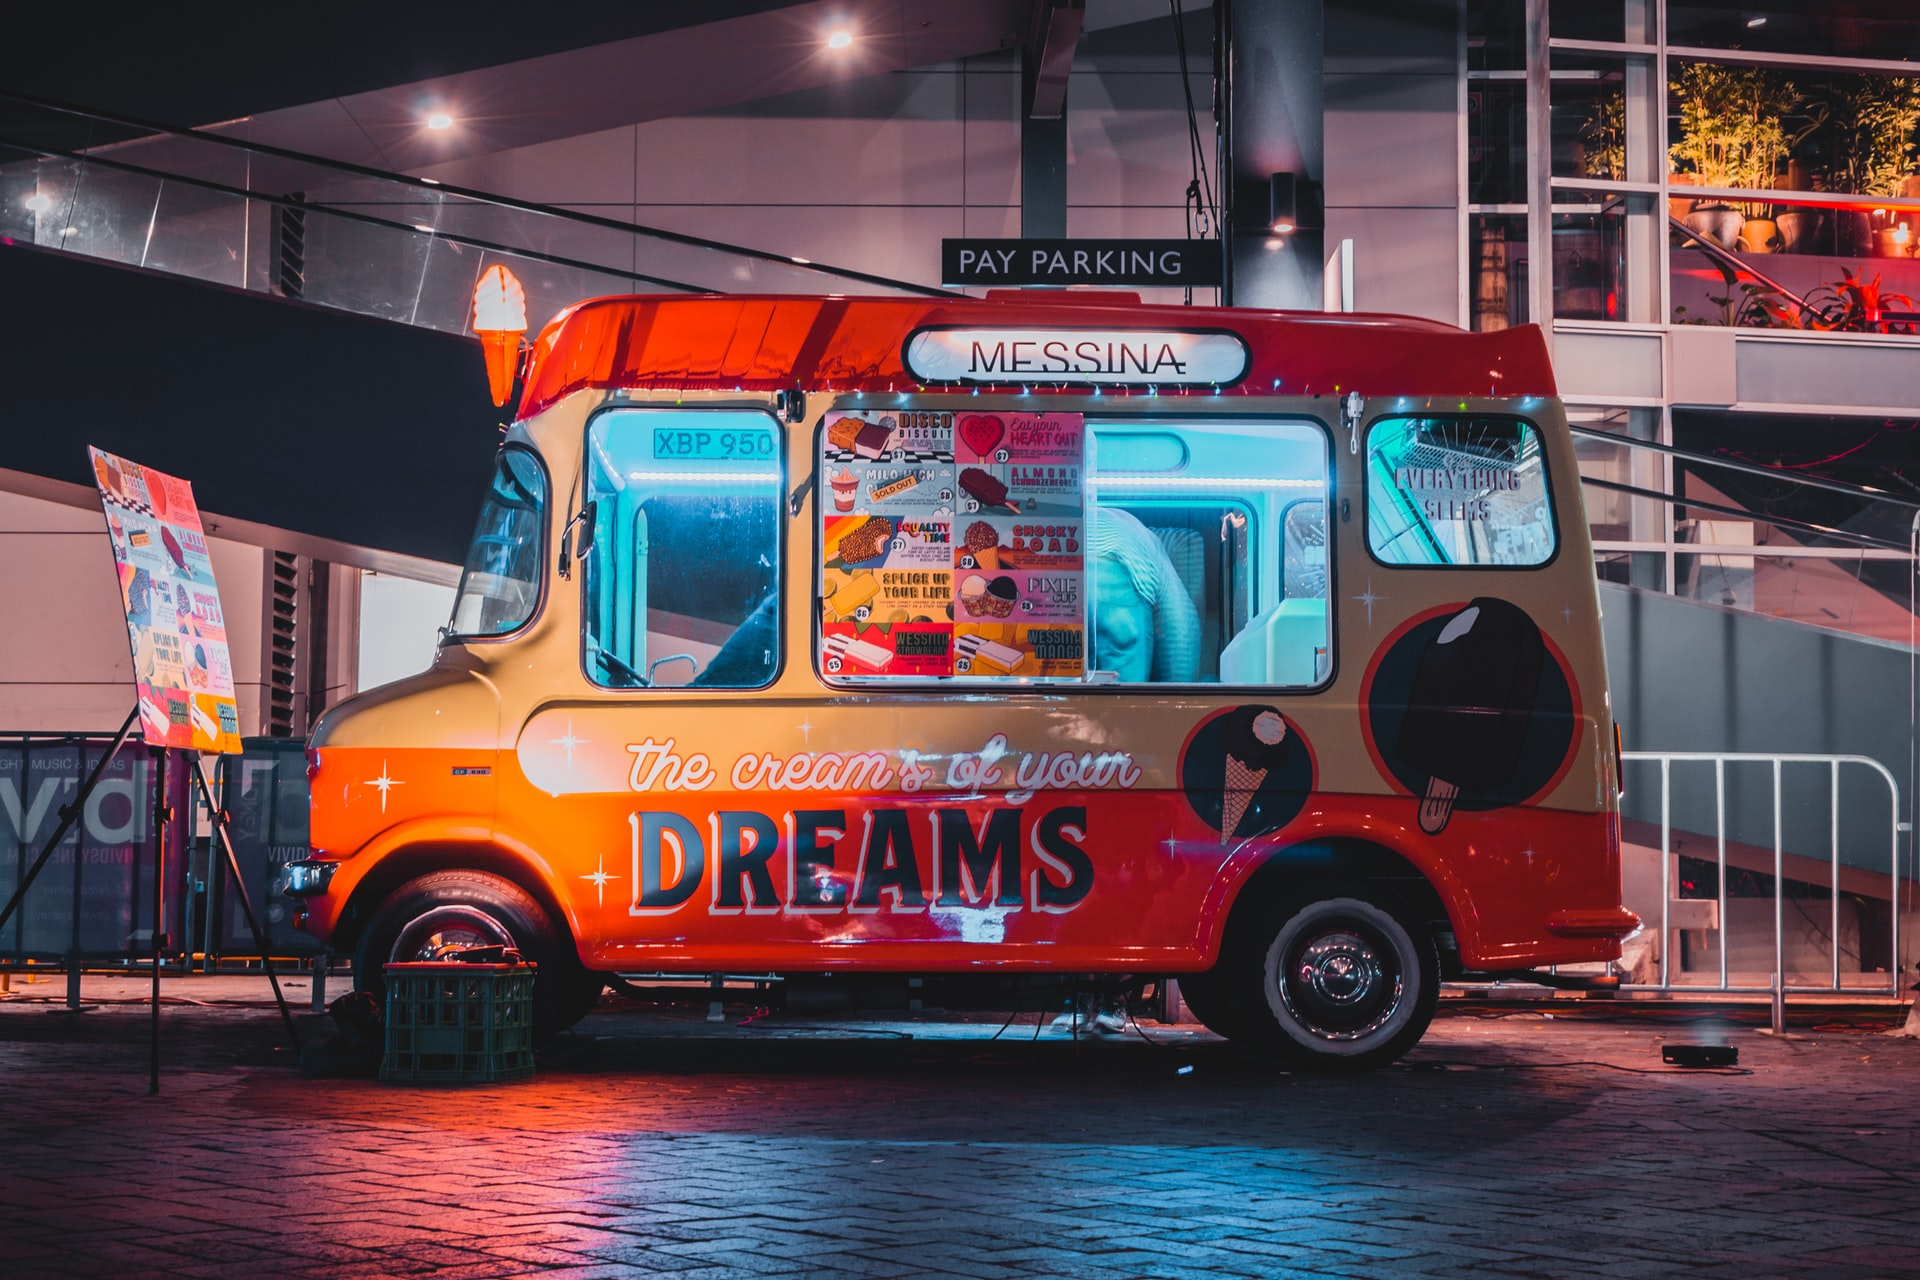
Photo by Benjamin Sow on [unsplash.com](https://unsplash.com/photos/0FtWjW6-FPg)

Crowdfunding has emerged as an effective mechanism for raising capital for early-stage ventures. Enabled by peer-to-peer internet platforms that connect entrepreneurs with funders, crowdfunding allows entrepreneurs to pitch their venture ideas and draw on small contributions from many funders. Crowdfunding has gained popularity worldwide with about $200 billion in market size and is expected to surpass venture capital spending as the primary source of startup financing.

Given the growing inﬂuence of crowdfunding platforms, I examine the effectiveness of the communication that entrepreneurs use in their crowdfunding pitches to secure funding for their ventures. I use Natural Language Processing (NLP) and XGBoost machine learning model to predict funding success based on information contained in campaigns' narratives. 

Data were collected for all Kickstarter campaigns launched in the US in 2016. The campaign text descriptions were web scrapped from [kickstarter.com](https://www.kickstarter.com/). The resulting dataset amounted to 21,711 campaigns: 9,717 funded and 11,994 unfunded.

The resulting model produced a precision score for successfully funded campaigns of 0.75, which is pretty good considering that text predictors have no apriori theoretical basis. That is, among 1,951 funded campaigns, the model correctly classified 1,456 in a holdout test data set using the text data only.

In [5]:
# Importing Python libraries
import re
from sklearn.datasets import load_files
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Importing Data
I use the load_files function from the sklearn_datasets library to import the dataset. The load_files function automatically divides the dataset into data and target sets. The load_files function loads the data from both "neg"(unfunded) and "pos"(funded) subfolders into the docs variable, while the target categories are stored in y (coded 0 and 1).

In [4]:
data = load_files(r"C:\Users\mag158\Desktop\text files", random_state=0)
docs, y = data.data, data.target
print("Samples per class: {}".format(np.bincount(y)))

Samples per class: [11994  9717]


## Text Processing
Once the dataset has been imported, the next step is to preprocess the text. Text may contain numbers, special characters, and unwanted spaces. I remove all the text's special characters, numbers, and unwanted spaces.

I use Regex Expressions from Python re library to perform different preprocessing tasks. I start by removing all non-word characters such as special characters, numbers, etc.

I remove all the single characters. For instance, when we remove the punctuation mark from "David's" and replace it with a space, I get "David" and a single character "s," which has no meaning. To remove such single characters, I use \s+[a-zA-Z]\s+ regular expression, which substitutes all the single characters having spaces on either side with a single space.

I use the \^[a-zA-Z]\s+ regular expression to replace a single character from the beginning of the document with a single space. Replacing single characters with a single space may result in multiple spaces, which is not ideal.

I again use the regular expression \s+ to replace one or more spaces with a single space. The alphabet letter "b" is appended before every string when you have a dataset in bytes format. The regex ^b\s+ removes "b" from the start of a string. The next step is to convert the data to lower case so that the same words but have different cases can be treated equally.

The final preprocessing step is lemmatization. In lemmatization, I reduce the word into dictionary root form. For instance, "cats" is converted into "cat." Lemmatization is done to avoid creating semantically similar but syntactically different features. For example, I don't want two features named "cats" and "cat," which are semantically similar. Therefore, I perform lemmatization.

In [8]:
#remove all the special characters, numbers, unwanted spaces, etc. from text
stemmer = WordNetLemmatizer()
clean_docs = []

for sen in range(0, len(docs)):
    #remove special characters
    doc = re.sub(r'\W', ' ', str(docs[sen]))
    
    #remove single characters
    doc = re.sub(r'\s+[a-zA-Z]\s+', ' ', doc)
    
    #remove single characters from start
    doc = re.sub(r'\^[a-zA-Z]\s+', ' ', doc) 
    
    #substitute multiple spaces with single space
    doc = re.sub(r'\s+', ' ', doc, flags=re.I)
    
    #remove prefixed 'b'
    doc = re.sub(r'^b\s+', '', doc)
    
    #remove 'xef xbb xbf'
    doc = re.sub('xef xbb xbf', '', doc)
    
    #remove digits
    doc = re.sub('\d', '', doc)
    
    #remove first letter 'n'
    doc = re.sub('n', '', doc, count=1)
    
    #remove 'xc xa'
    doc = re.sub('xc xa', '', doc)
    
    #converte to lowercase
    doc = doc.lower()
    
    #lemmatization
    doc = doc.split()
    doc = [stemmer.lemmatize(word) for word in doc]
    doc = ' '.join(doc)
    
    #append cleaned docs to list
    clean_docs.append(doc)

X = clean_docs

## Converting Text to Numbers

I use tf–idf, a numerical statistic intended to reflect how important a word is to a document in a collection or corpus. The TF stands for "Term Frequency" while IDF stands for "Inverse Document Frequency." The tf–idf value increases proportionally to the number of times a word appears in the document. It is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. The term frequency is calculated as Term frequency = (Number of Occurrences of a word) / (Total words in the document). The tf–idf value for a word in a particular document is higher if the frequency of occurrence of that word is higher in that specific document but lower in all the other documents. 

## Training Text Classification Model and Predicting Funding Outcomes 

To determine the predictive capacity of the ML model, I split the data into a training set and a testing set. I use the pipeline tool combined with RandomizedSearchCV to assemble several steps that can be cross-validated while setting different parameters. Because tf–idf makes use of the statistical properties of the training data, I use a pipeline to ensure the results of the grid search are valid. As such, the preprocessing step in the pipeline includes TfidfVectorizer. I use XGBoost for classification. RandomizedSearchCV runs through 100 randomly selected combinations of various parameters fed into the parameter grid and produces the best combination of parameters based on the precision scoring metric.

In [1]:
#import ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
#Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [9]:
# Create pipeline
pipe = make_pipeline(TfidfVectorizer(stop_words=stopwords.words('english')),
                     xgb.XGBClassifier(objective='binary:logistic', 
                     random_state=0, n_jobs=-1))

In [10]:
# Specify hyperparameter space
parameters = {
    'xgbclassifier__learning_rate': np.arange(.05, 1, .05),
    'xgbclassifier__max_depth': np.arange(3, 10, 1),
    'xgbclassifier__n_estimators': np.arange(50, 200, 50),
    'xgbclassifier__eta': [0.001, 0.01, 0.1],
    'xgbclassifier__colsample_bytree': [0.1, 0.5, 0.8, 1],
    
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__max_features': [500, 1000, 1500],
    'tfidfvectorizer__min_df': [5, 7],
    'tfidfvectorizer__max_df': [0.5, 0.7]
}

In [11]:
# Instantiate RandomizedSearchCV object
grid = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_iter=20, 
                          scoring='precision', cv=5, verbose=3, n_jobs=-1)

In [12]:
#Fit to training set
model = grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


# Results
This model produced a precision score for funded campaigns of 0.75, which is pretty good considering that text predictors have no apriori theoretical basis. That is, among 1,951 successfully funded campaigns, the model correctly classified 1,456 in a holdout test data set using the text data only. Because this test set score of the model is not significantly worse than the cross-validation score during training (0.76), the model is not likely to overfit and can be considered reliable.

In [13]:
# Get performance metrics
predict = model.predict(X_test)
print("Best cross-validation score: {:.2f}".format(model.best_score_))
print("Test set score: {:.2f}".format(model.score(X_test, y_test)))
print (classification_report(y_test, predict))
print("Best params:\n{}\n".format(model.best_params_))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, predict)))

Best cross-validation score: 0.76
Test set score: 0.75
              precision    recall  f1-score   support

           0       0.72      0.83      0.77      2999
           1       0.75      0.60      0.66      2429

    accuracy                           0.73      5428
   macro avg       0.73      0.72      0.72      5428
weighted avg       0.73      0.73      0.72      5428

Best params:
{'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__eta': 0.001, 'xgbclassifier__colsample_bytree': 0.1, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__max_features': 1500, 'tfidfvectorizer__max_df': 0.5}

Confusion matrix:
[[2504  495]
 [ 973 1456]]
